In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Meet the Data

In [3]:
from research_data import paths_pairs

!find Research-Data/* -type d -exec sh -c \
    'printf "%22s has %2d subjects\n" "{}" $(ls "{}"/*.genes.txt | wc -l)' \;

      Research-Data/CR has  8 subjects
    Research-Data/CRMs has 12 subjects
 Research-Data/Fasting has  4 subjects


In [4]:
from parse_genes import k_most_expressed_genes
from parse_desc import parse_desc_file
import json

# example
desc_path, genes_path = next(iter(paths_pairs))

print(f"""
{(desc_path, genes_path)}

{json.dumps(parse_desc_file(desc_path), indent=2, sort_keys=True)}

k=10 most expressed genes: """)
k_most_expressed_genes(genes_path, k=10)


('Research-Data/CR/1.desc.txt', 'Research-Data/CR/1.genes.txt')

{
  "Caloric Restriction Duration": "8 months",
  "Deficit Size": "60% of daily intake",
  "Name": "CR Group 1",
  "Organism": "mouse"
}

k=10 most expressed genes: 


,gene_symbol,logFC
0,cyp2b13,3.802507
1,fmo3,3.735119
2,anxa11,3.422603
3,gm43302,-3.062555
4,ccl21d,-3.044070
5,gm10273,3.017953
6,cidea,-2.436414
7,igkv3-2,-2.420975
8,gm4459,2.270074
9,mmp9,-2.265182


## Gene Expression Matrix

In [29]:
from parse_genes import all_genes_in_file


def full_gene_expression_table():
    # Load the Gene Expression Table of each Treatment
    all_data = []
    for desc_path, genes_path in paths_pairs:
        df = all_genes_in_file(genes_path)
        df['treatment_name'] = parse_desc_file(desc_path)['Name']
        all_data.append(df)

    # Combine all dataframes
    combined_data = pd.concat(all_data, ignore_index=True)
    result = combined_data.pivot_table(values='logFC', index='treatment_name', columns='gene_symbol', fill_value=np.nan)
    result.index.name = None
    result.columns.name = ''
    
    # Filter out columns with less than X values
    mask = (~np.isnan(result)).sum(axis=0) >= 5
    result = result.loc[:, mask]

    return result
    
    
matrix = full_gene_expression_table()
matrix

,aak1,aasdhppt,aatf,abat,abca1,abca2,abca3,abca5,abca7,abcb10,...,znhit1,znrd2,znrf1,zranb2,zscan29,zswim8,zup1,zwint,zyg11b,zzef1
2-deoxyglucose,NaN,NaN,0.265309,NaN,NaN,NaN,NaN,0.311530,NaN,NaN,...,NaN,-0.271062,NaN,0.126578,0.452929,NaN,0.292162,NaN,NaN,NaN
"3,4-dimethoxychalcone",0.440950,NaN,NaN,NaN,NaN,0.271501,0.250484,0.368857,0.349240,NaN,...,-0.396759,-0.421251,NaN,NaN,NaN,0.293099,NaN,NaN,0.371783,0.511987
CR Group 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.256019,NaN,NaN,NaN
CR Group 3,NaN,NaN,NaN,0.577098,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR Group 4,0.137556,-0.227263,NaN,NaN,NaN,0.255923,0.235131,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.334411,0.114844,NaN,-0.125596,NaN,0.190000
CR Group 5,NaN,NaN,NaN,NaN,0.533809,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR Group 6,NaN,NaN,-0.341004,-0.319928,1.453241,NaN,NaN,1.621258,NaN,-0.361213,...,NaN,NaN,0.720651,NaN,NaN,0.971682,NaN,-0.711630,NaN,1.186804
CR Group 7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CR Group 8,NaN,NaN,NaN,NaN,NaN,-0.997296,NaN,NaN,-0.862010,-0.758970,...,NaN,NaN,NaN,NaN,NaN,NaN,0.944999,-1.045234,NaN,NaN
CR Group 9,NaN,0.142986,NaN,NaN,0.297084,NaN,-0.373626,NaN,NaN,0.422742,...,0.311542,NaN,0.395292,0.253131,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
missing_percentage = matrix.isna().mean().mean() * 100
print(f"Total missing values percentage: {missing_percentage:.2f}%")

Total missing values percentage: 75.71%


In [31]:
from sklearn.model_selection import train_test_split

# Step 1: Get list of (i, j) coordinates where the values are not NaN
non_nan_coords = np.argwhere(~np.isnan(matrix.values))

# Step 2: Randomly sample 15% of these coordinates for the test set
train_coords, test_coords = train_test_split(non_nan_coords, test_size=0.15, random_state=42)

# Step 3: Create the train_matrix where 15% of the values are replaced with NaN
train_matrix = matrix.copy()

# 4. Set the 15% of test coordinates to NaN in the train matrix
train_matrix.values[test_coords[:, 0], test_coords[:, 1]] = np.nan

In [32]:
total_matrix_vals = (~np.isnan(matrix)).sum().sum()
total_train_matrix_vals = (~np.isnan(train_matrix)).sum().sum()

print(f"{total_matrix_vals = :,}")
print(f"total_train_vals {total_train_matrix_vals:,}")
print(f"total_test_vals = {total_matrix_vals - total_train_matrix_vals:,}")

total_matrix_vals = 21,657
total_train_vals 18,408
total_test_vals = 3,249


## Matrix Completion using SoftImpute

In [33]:
from fancyimpute import SoftImpute

# Convert the DataFrame to a NumPy array
data_train_matrix = train_matrix.values

# Apply SoftImpute
completed_train_matrix = SoftImpute().fit_transform(data_train_matrix)

[SoftImpute] Max Singular Value of X_init = 53.747120
[SoftImpute] Iter 1: observed MAE=0.026210 rank=22
[SoftImpute] Iter 2: observed MAE=0.026211 rank=22
[SoftImpute] Iter 3: observed MAE=0.026209 rank=22
[SoftImpute] Iter 4: observed MAE=0.026205 rank=22
[SoftImpute] Iter 5: observed MAE=0.026200 rank=22
[SoftImpute] Iter 6: observed MAE=0.026194 rank=22
[SoftImpute] Iter 7: observed MAE=0.026187 rank=22
[SoftImpute] Iter 8: observed MAE=0.026180 rank=22
[SoftImpute] Iter 9: observed MAE=0.026172 rank=22
[SoftImpute] Iter 10: observed MAE=0.026164 rank=22
[SoftImpute] Iter 11: observed MAE=0.026156 rank=22
[SoftImpute] Iter 12: observed MAE=0.026139 rank=21
[SoftImpute] Iter 13: observed MAE=0.026117 rank=21
[SoftImpute] Iter 14: observed MAE=0.026102 rank=21
[SoftImpute] Iter 15: observed MAE=0.026090 rank=21
[SoftImpute] Iter 16: observed MAE=0.026079 rank=21
[SoftImpute] Iter 17: observed MAE=0.026069 rank=21
[SoftImpute] Iter 18: observed MAE=0.026059 rank=21
[SoftImpute] Iter 1

In [34]:
from sklearn.metrics.pairwise import cosine_similarity


threshold_abs_logFC = 0.3

def assess_prediction(predicted_full_matrix):
    test_true = matrix.values[test_coords[:, 0], test_coords[:, 1]]
    test_pred = predicted_full_matrix[test_coords[:, 0], test_coords[:, 1]]

    # Compute cosine similarity
    pred_cos_sim = cosine_similarity(test_true.reshape(1, -1), test_pred.reshape(1, -1))[0][0]
    print(f"Cosine Similarity of Prediction vs. True: {pred_cos_sim:.3f}")
    
    sign_agreement = _assess_agreement(test_true, test_pred)
    print(f"Sign Agreement for Significant Values: {sign_agreement:.2f}%")


def _assess_agreement(test_true, test_pred):
    # Identify indices of significant true values
    significant_indices = np.where(np.abs(test_true) >= threshold_abs_logFC)[0]

    # Extract significant true and predicted values and Compare signs
    true_signs = np.sign(test_true[significant_indices])
    pred_signs = np.sign(test_pred[significant_indices])

    # Calculate the percentage of sign agreements
    return np.mean(true_signs == pred_signs) * 100

    
assess_prediction(completed_train_matrix)

Cosine Similarity of Prediction vs. True: 0.380
Sign Agreement for Significant Values: 70.23%


## Cosine Sim

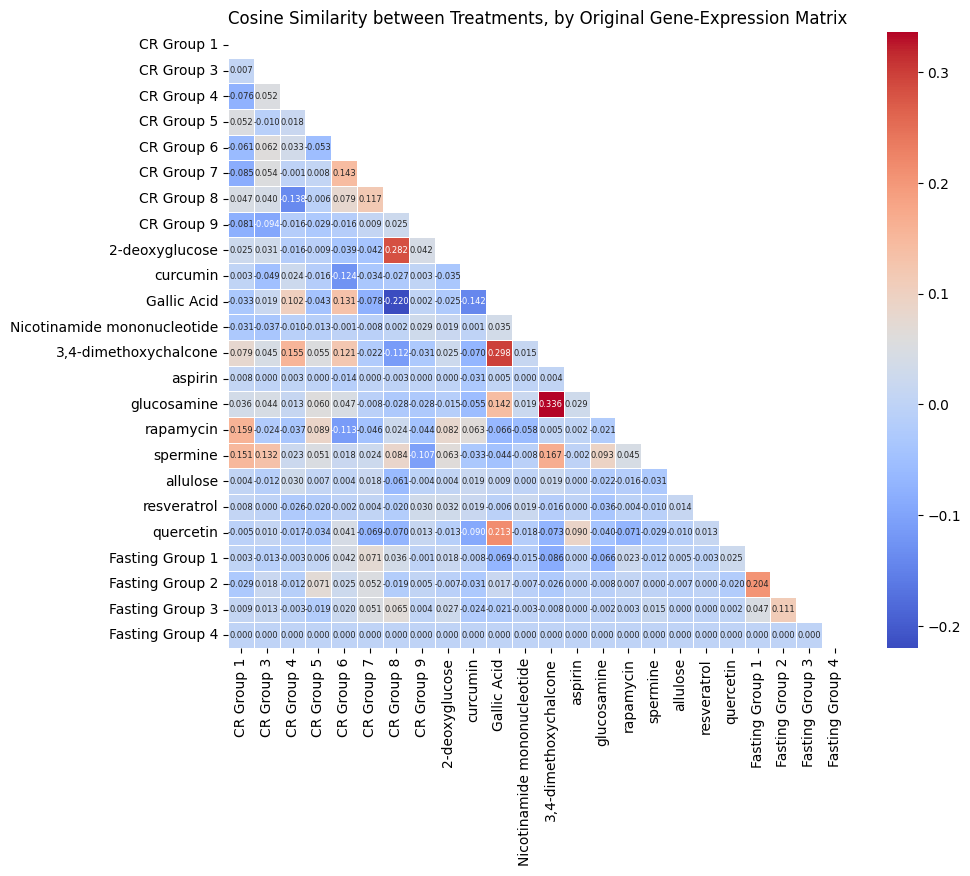

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
from parse_desc import treatment_names


def compute_cosine_sim(gene_expressions):
    gene_expressions = gene_expressions.copy()
    gene_expressions = gene_expressions.fillna(0.0)
    # Normalize each row
    norms = np.linalg.norm(gene_expressions, axis=1)
    norms = np.where(norms == 0, np.finfo(float).eps, norms)
    normalized_matrix = gene_expressions.div(norms, axis=0)

    # Compute cosine similarity
    cos_sim_matrix = cosine_similarity(normalized_matrix)

    # Create DataFrame, and preserve indices
    cos_sim_df = pd.DataFrame(cos_sim_matrix, index=gene_expressions.index, columns=gene_expressions.index)

    # Re-order rows and columns based on 'node_names'
    cos_sim_df = cos_sim_df.reindex(index=treatment_names, columns=treatment_names)
    
    # Set diagonal to 0s
    np.fill_diagonal(cos_sim_df.values, 0)

    return cos_sim_df


def plot_cosine_sim(gene_expressions, title):
    cos_sim_df = compute_cosine_sim(gene_expressions)

    # Mask the lower triangle including diagonal
    mask = np.triu(np.ones_like(cos_sim_df, dtype=bool))

    # Set diagonal to NaN for visualization clarity
    np.fill_diagonal(cos_sim_df.values, np.nan)

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim_df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, 
                linewidths=.5, mask=mask, annot_kws={'size': 6})
    plt.title(title)
    plt.show()
    
    
plot_cosine_sim(matrix, f'Cosine Similarity between Treatments, by Original Gene-Expression Matrix')


In [36]:
# Predict Missing Values in Entire Data Set
completed_full_matrix = SoftImpute().fit_transform(matrix.values)

[SoftImpute] Max Singular Value of X_init = 59.029024
[SoftImpute] Iter 1: observed MAE=0.026354 rank=22
[SoftImpute] Iter 2: observed MAE=0.026353 rank=22
[SoftImpute] Iter 3: observed MAE=0.026349 rank=22
[SoftImpute] Iter 4: observed MAE=0.026343 rank=22
[SoftImpute] Iter 5: observed MAE=0.026336 rank=22
[SoftImpute] Iter 6: observed MAE=0.026328 rank=22
[SoftImpute] Iter 7: observed MAE=0.026319 rank=22
[SoftImpute] Iter 8: observed MAE=0.026310 rank=22
[SoftImpute] Iter 9: observed MAE=0.026300 rank=22
[SoftImpute] Iter 10: observed MAE=0.026290 rank=22
[SoftImpute] Iter 11: observed MAE=0.026280 rank=22
[SoftImpute] Iter 12: observed MAE=0.026266 rank=21
[SoftImpute] Iter 13: observed MAE=0.026243 rank=21
[SoftImpute] Iter 14: observed MAE=0.026227 rank=21
[SoftImpute] Iter 15: observed MAE=0.026213 rank=21
[SoftImpute] Iter 16: observed MAE=0.026201 rank=21
[SoftImpute] Iter 17: observed MAE=0.026189 rank=21
[SoftImpute] Iter 18: observed MAE=0.026178 rank=21
[SoftImpute] Iter 1

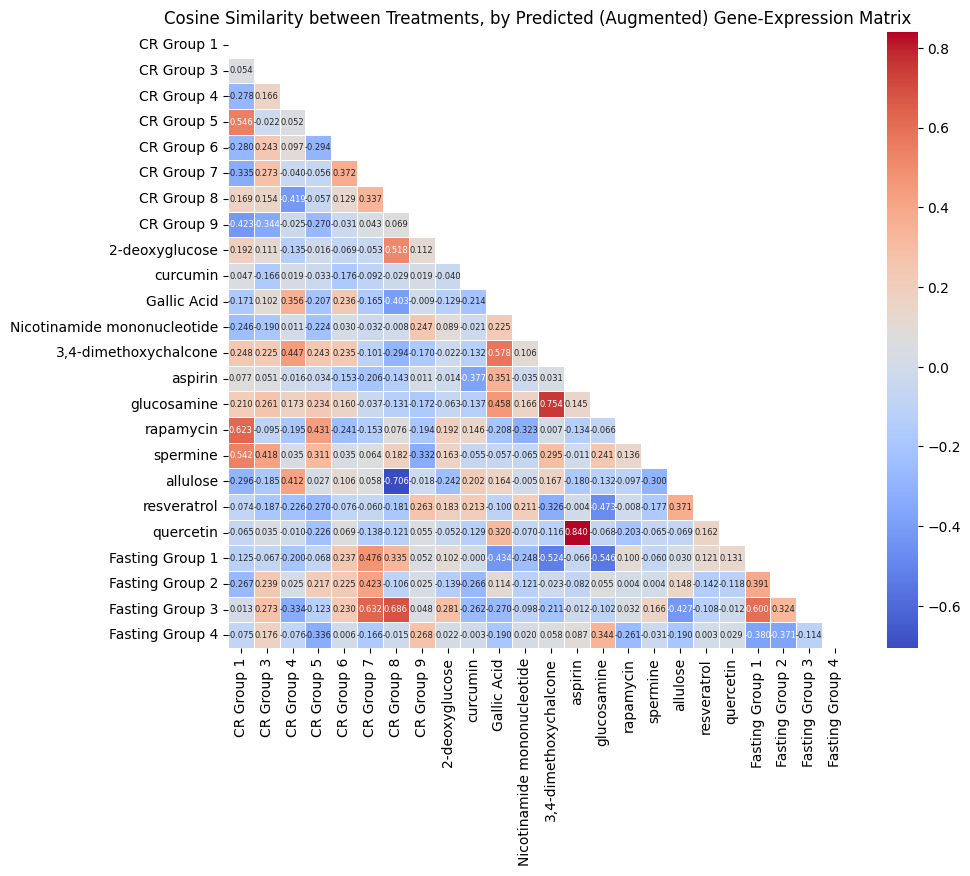

In [39]:
completed_full_matrix = pd.DataFrame(completed_full_matrix, index=matrix.index, columns=matrix.columns)

plot_cosine_sim(completed_full_matrix, f'Cosine Similarity between Treatments, by Predicted (Augmented) Gene-Expression Matrix')

In [56]:
total_sim_values = len(matrix.index) * (len(matrix.index) - 1) // 2

print(f"{total_sim_values = }")

total_sim_values = 276


In [97]:
top_fraction = 0.05

"""
Only take this precentage of highest similarity values
"""

top_n = int(total_sim_values * top_fraction)

print(f"{top_n = }")

top_n = 13


In [98]:
def extract_top_similar_pairs(cos_sim_df):
  sim_pairs = []

  for i in range(len(cos_sim_df)):
    for j in range(i + 1, len(cos_sim_df)):
      treatment1 = cos_sim_df.index[i]
      treatment2 = cos_sim_df.columns[j]
      cos_sim = cos_sim_df.iloc[i, j]
      
      sim_pairs.append((frozenset([treatment1, treatment2]), cos_sim))

  sorted_pairs = sorted(sim_pairs, key=lambda x: x[1], reverse=True)

  return [*map(lambda pair: pair[0], sorted_pairs[:top_n])]


In [102]:
original_top_links = extract_top_similar_pairs(
    compute_cosine_sim(matrix), 
)

print("Original Top Links (Before Augmentation):")

for pair in original_top_links:
  print(f"{set(pair)}")

Original Top Links (Before Augmentation):
{'3,4-dimethoxychalcone', 'glucosamine'}
{'Gallic Acid', '3,4-dimethoxychalcone'}
{'CR Group 8', '2-deoxyglucose'}
{'Gallic Acid', 'quercetin'}
{'Fasting Group 1', 'Fasting Group 2'}
{'3,4-dimethoxychalcone', 'spermine'}
{'rapamycin', 'CR Group 1'}
{'3,4-dimethoxychalcone', 'CR Group 4'}
{'CR Group 1', 'spermine'}
{'CR Group 7', 'CR Group 6'}
{'Gallic Acid', 'glucosamine'}
{'spermine', 'CR Group 3'}
{'Gallic Acid', 'CR Group 6'}


In [103]:
prediction_top_links = extract_top_similar_pairs(
    compute_cosine_sim(completed_full_matrix), 
)

print("Prediction Top Links (After Augmentation):")

for pair in prediction_top_links:
  print(f"{set(pair)}")

Prediction Top Links (After Augmentation):
{'aspirin', 'quercetin'}
{'3,4-dimethoxychalcone', 'glucosamine'}
{'Fasting Group 3', 'CR Group 8'}
{'CR Group 7', 'Fasting Group 3'}
{'rapamycin', 'CR Group 1'}
{'Fasting Group 1', 'Fasting Group 3'}
{'Gallic Acid', '3,4-dimethoxychalcone'}
{'CR Group 5', 'CR Group 1'}
{'CR Group 1', 'spermine'}
{'CR Group 8', '2-deoxyglucose'}
{'CR Group 7', 'Fasting Group 1'}
{'Gallic Acid', 'glucosamine'}
{'3,4-dimethoxychalcone', 'CR Group 4'}


In [106]:
print("Intersection Between Original and Augmentated Top Links:")

diff = set(prediction_top_links) & set(original_top_links)

for pair in diff:
  print(f"{set(pair)}")

Intersection Between Original and Augmentated Top Links:
{'Gallic Acid', '3,4-dimethoxychalcone'}
{'Gallic Acid', 'glucosamine'}
{'rapamycin', 'CR Group 1'}
{'3,4-dimethoxychalcone', 'CR Group 4'}
{'3,4-dimethoxychalcone', 'glucosamine'}
{'CR Group 1', 'spermine'}
{'CR Group 8', '2-deoxyglucose'}


In [105]:
print("Difference Between Original and Augmentated Top Links:")

diff = set(prediction_top_links) - set(original_top_links)

for pair in diff:
  print(f"{set(pair)}")

Difference Between Original and Augmentated Top Links:
{'Fasting Group 3', 'CR Group 8'}
{'aspirin', 'quercetin'}
{'CR Group 7', 'Fasting Group 3'}
{'CR Group 7', 'Fasting Group 1'}
{'Fasting Group 1', 'Fasting Group 3'}
{'CR Group 5', 'CR Group 1'}
